In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from knee_stress_predict.config import processed_data_dir
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.cluster import KMeans


## Load data

In [2]:
data_set_name = "set_3"
train_file_path = Path.joinpath(processed_data_dir, data_set_name,  "train_cleaned.csv")
test_file_path = Path.joinpath(processed_data_dir, data_set_name,  "test_cleaned.csv")
train_data = pd.read_csv(train_file_path).drop('Unnamed: 0', axis=1)
test_data = pd.read_csv(test_file_path).drop('Unnamed: 0', axis=1)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27715 entries, 0 to 27714
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code                           27715 non-null  object 
 1   Patella_PN                     27715 non-null  int64  
 2   Femur_PN                       27715 non-null  int64  
 3   Tibia_PN                       27715 non-null  int64  
 4   Patella_Car_PN                 27715 non-null  int64  
 5   Femur_Car_PN                   27715 non-null  int64  
 6   Tibia_M_Car_PN                 27715 non-null  int64  
 7   Tibia_L_Car_PN                 27715 non-null  int64  
 8   Patella_volume                 27715 non-null  float64
 9   Femur_volume                   27715 non-null  float64
 10  Tibia_volume                   27715 non-null  float64
 11  Patella_Car_volume             27715 non-null  float64
 12  Femur_Car_volume               27715 non-null 

In [4]:
def get_tframe_dataset(tframe_num, dataset):
    tframe_dataset = dataset[dataset['frame'] == tframe_num]
    return tframe_dataset

In [5]:
train_datasets = get_tframe_dataset(0, train_data)
test_datasets = get_tframe_dataset(0, test_data)

## Drop unnecessary columns

We need to delete "Max_tib_med_contact_pressure" and "Max_tib_lat_contact_pressure" since these features are for 0-time points only. In this notebook, we are more concentrated on maximal contact pressure, which are: "med_Max_all_frames" and "lat_Max_all_frames"

In [6]:
train_datasets = train_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

test_datasets = test_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

In [7]:
train_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,139880.512171,...,1,19.629001,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,15.890460,34.044975
241,1126,4113,2684,5900,21030,2840,2840,33039.218053,228671.171460,134963.134980,...,1,22.935425,13.560157,0.800195,6.226970,10.677269,1.029139,4.306716,20.057634,31.649405
482,771,3414,2596,4485,18385,2840,2840,21736.919532,184294.924991,127637.611277,...,1,19.539911,12.892850,1.504442,4.844820,9.243396,1.418712,4.015682,18.555532,26.223894
723,730,3404,2600,5055,18755,2840,2840,20866.993760,184114.045604,128295.783408,...,1,18.387004,11.617199,1.119438,4.698536,9.107268,1.398252,3.890993,19.447876,24.808067
964,667,3814,2631,5245,19370,2840,2840,17949.168458,221202.458278,137472.394625,...,1,19.128202,12.324972,2.210197,6.003760,10.941657,2.428147,5.948101,19.930437,25.919180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26510,686,2963,2388,4405,20910,2155,2840,15821.015946,140615.628188,110523.109264,...,1,19.857552,18.010511,1.444001,5.899954,13.425811,1.667098,5.354239,27.401314,34.442417
26751,795,3669,2724,4765,20410,2840,2840,22375.020348,207318.185631,146786.471170,...,1,22.148186,16.633343,1.874496,6.641354,15.426130,2.258161,4.898385,19.478767,22.278835
26992,801,3805,2575,4885,20400,2840,2840,22439.863013,215968.865103,136753.285023,...,1,22.762806,17.640301,1.481010,6.875417,12.561378,2.246910,4.471387,20.616781,26.929873
27233,868,3794,3029,5430,20755,2840,2840,25084.417057,216622.182978,168327.403757,...,1,19.888791,19.743281,2.204936,6.574413,16.267729,1.759706,5.525146,17.599583,22.764488


In [8]:
test_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,138731.987496,...,1,17.180449,12.178187,1.852458,6.176293,9.838347,1.248360,5.243077,20.998919,21.368145
241,816,3471,2805,5045,20905,2840,2840,23077.844638,194402.116965,153097.503228,...,1,19.552980,17.436416,1.832786,7.209798,11.834508,1.773031,5.090567,16.342916,24.726450
482,781,3906,2604,5105,20875,2840,2840,18940.943691,229538.339366,133149.812222,...,1,17.651614,16.163145,1.537181,5.402839,10.835806,2.228766,5.153152,26.878704,20.836784
723,531,2696,2023,4205,17575,2840,2840,12678.464250,125961.766310,91553.631588,...,1,19.605713,13.193326,0.692153,4.076171,10.188166,0.872813,3.153680,33.084023,41.899796
964,555,2867,2215,3915,19845,2840,2840,13201.065463,146557.241204,109181.460201,...,1,16.593467,14.282174,1.322267,5.516642,10.594452,0.796869,3.753957,18.879358,30.542082
1205,856,3741,2639,4765,21095,2840,2840,24802.070768,207480.555638,132782.842515,...,1,22.239408,17.744752,2.717176,7.807945,14.243176,2.215854,5.845854,27.747881,39.927299
1446,833,3828,2647,4945,18155,2840,2840,24544.137968,220856.274195,142191.973295,...,1,19.109862,16.368454,1.582719,5.936896,9.762050,1.829145,4.255408,24.238981,25.002775
1687,785,3686,2669,4050,21750,2840,2840,22224.955876,205583.220678,139236.369399,...,1,21.568833,14.102408,1.646955,6.274178,11.181971,1.453194,5.181219,18.729412,25.375481
1928,922,3866,2738,4645,21800,2340,2840,26822.466759,217761.486440,143150.197170,...,1,24.568038,22.752636,1.440737,7.901696,17.943346,0.774024,5.269343,21.266918,26.806919
2169,706,3320,2170,3360,20680,4260,2840,18799.562749,164129.999650,97898.558255,...,1,44.107787,10.271868,1.303613,4.619040,9.772798,1.245017,3.984866,23.169041,22.456438


(array([ 3.,  9.,  9., 11., 21., 12., 15.,  9., 11.,  2.,  2.,  3.,  3.,
         0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([13.80844021, 15.32736839, 16.84629656, 18.36522474, 19.88415292,
        21.4030811 , 22.92200928, 24.44093746, 25.95986563, 27.47879381,
        28.99772199, 30.51665017, 32.03557835, 33.55450652, 35.0734347 ,
        36.59236288, 38.11129106, 39.63021924, 41.14914742, 42.66807559,
        44.18700377, 45.70593195, 47.22486013, 48.74378831, 50.26271648,
        51.78164466, 53.30057284, 54.81950102, 56.3384292 , 57.85735737,
        59.37628555]),
 <BarContainer object of 30 artists>)

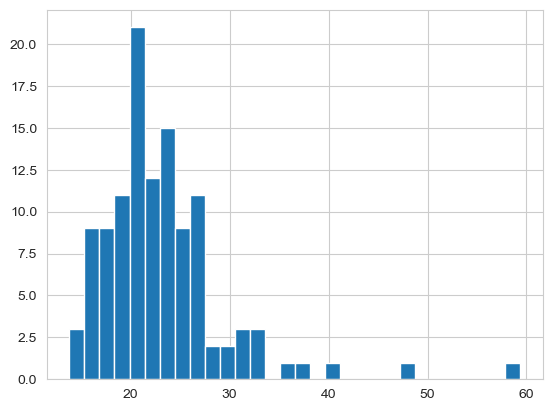

In [9]:
plt.hist(train_datasets[['lat_Max_all_frames']], bins = 30)

## MSE Naive Benchmark

In [10]:
predicted_pressure_med = np.mean(train_datasets[['med_Max_all_frames']])
predicted_pressure_lat = np.mean(train_datasets[['lat_Max_all_frames']])
print(f"Average medial cartilage pressure: {predicted_pressure_med}")
print(f"Average lateral cartilage pressure: {predicted_pressure_lat}")

n = len(test_datasets[['lat_Max_all_frames']])

simple_prediction_med = [predicted_pressure_med for i in range(n)]
simple_prediction_lat = [predicted_pressure_lat for i in range(n)]


Average medial cartilage pressure: med_Max_all_frames    29.375729
dtype: float64
Average lateral cartilage pressure: lat_Max_all_frames    23.144449
dtype: float64


### Metrics for naive prediction

In [11]:
# The mean squared error
mse_mean_med = mean_squared_error(simple_prediction_med, test_datasets[['med_Max_all_frames']])

mse_mean_lat = mean_squared_error(simple_prediction_lat, test_datasets[['lat_Max_all_frames']])

print("Mean squared error medial: %.2f" % mse_mean_med)
print("Mean squared error lateral: %.2f" % mse_mean_lat)

Mean squared error medial: 53.93
Mean squared error lateral: 25.28


## Logistic Regression
### Choose some features

#### Train data set

In [12]:
train_x_LR = train_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [13]:
train_y_lat_LR = train_datasets[['lat_Max_all_frames']]
train_y_med_LR = train_datasets[['med_Max_all_frames']]

#### Test data set

In [14]:
test_x_LR = test_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [15]:
test_y_lat_LR = test_datasets[['lat_Max_all_frames']]
test_y_med_LR = test_datasets[['med_Max_all_frames']]

### Train LR model

In [16]:
# define the model
# Create linear regression object
regr_lat = linear_model.LinearRegression()
regr_med = linear_model.LinearRegression()

# Train the model using the training sets
regr_lat.fit(train_x_LR, train_y_lat_LR)
regr_med.fit(train_x_LR, train_y_med_LR)

LinearRegression()

### Verify results

In [17]:
# Make predictions using the testing set
test_y_med_LR_pred = regr_med.predict(test_x_LR)
test_y_lat_LR_pred = regr_lat.predict(test_x_LR)

In [18]:
mse_LR_med = mean_squared_error(test_y_med_LR_pred, test_y_med_LR)
mse_LR_lat = mean_squared_error(test_y_lat_LR_pred, test_y_lat_LR)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_LR_med)
print("Mean squared error lateral: %.2f" % mse_LR_lat)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination medial: %.2f" % r2_score(test_y_med_LR_pred, test_y_med_LR))
print("Coefficient of determination lateral: %.2f" % r2_score(test_y_lat_LR_pred, test_y_lat_LR))

Mean squared error medial: 44.26
Mean squared error lateral: 28.09
Coefficient of determination medial: -0.19
Coefficient of determination lateral: -0.19


## Regularized Regression

In [19]:
train_x = train_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)
test_x = test_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)

In [20]:
train_y_lat = train_datasets[['lat_Max_all_frames']]
train_y_med = train_datasets[['med_Max_all_frames']]

test_y_lat = test_datasets[['lat_Max_all_frames']]
test_y_med = test_datasets[['med_Max_all_frames']]

### Lasso

In [21]:
model_lasso_lat = linear_model.Lasso(alpha=100, max_iter=1000000)
model_lasso_lat.fit(train_x, train_y_lat)

Lasso(alpha=100, max_iter=1000000)

In [22]:
model_lasso_med = linear_model.Lasso(alpha=100, max_iter=1000000)
model_lasso_med.fit(train_x, train_y_med)

Lasso(alpha=100, max_iter=1000000)

In [23]:
test_y_lat_lasso_predict = model_lasso_lat.predict(test_x)
test_y_mrd_lasso_predict = model_lasso_med.predict(test_x)

In [24]:
mse_lasso_med = mean_squared_error(test_y_med, test_y_mrd_lasso_predict)
mse_lasso_lat = mean_squared_error(test_y_lat, test_y_lat_lasso_predict )
# The mean squared error
print("Mean squared error medial: %.2f" % mse_lasso_med)
print("Mean squared error lateral: %.2f" % mse_lasso_lat)

Mean squared error medial: 39.33
Mean squared error lateral: 51.50


## Random Forest

In [25]:
n_estimator = 1000
model_rf_lat = RandomForestRegressor(n_estimators=n_estimator)
model_rf_med = RandomForestRegressor(n_estimators=n_estimator)

model_rf_lat.fit(train_x, train_y_lat)
model_rf_med.fit(train_x, train_y_med)
test_y_lat_rf_predict = model_rf_lat.predict(test_x)
test_y_med_rf_predict = model_rf_med.predict(test_x)


In [26]:
mse_RF_med = mean_squared_error(test_y_med, test_y_med_rf_predict)
mse_RF_lat = mean_squared_error(test_y_lat, test_y_lat_rf_predict)
# The mean squared error
print("Mean squared error medial: %.2f" % mse_RF_med)
print("Mean squared error lateral: %.2f" % mse_RF_lat)

Mean squared error medial: 36.58
Mean squared error lateral: 43.01


## XGBoost

In [27]:
model_xgb_lat = xgb.XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.6, colsample_bytree=0.8)
model_xgb_med = xgb.XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.6, colsample_bytree=0.8)

In [28]:
model_xgb_lat.fit(train_x, train_y_lat)
model_xgb_med.fit(train_x, train_y_med)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [29]:
test_y_lat_rgb_predict = model_xgb_lat.predict(test_x)
test_y_med_rgb_predict = model_xgb_med.predict(test_x)

In [30]:
mse_RGB_med = mean_squared_error(test_y_med, test_y_med_rgb_predict)
mse_RGB_lat = mean_squared_error(test_y_lat, test_y_lat_rgb_predict)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_RGB_med)
print("Mean squared error lateral: %.2f" % mse_RGB_lat)

Mean squared error medial: 40.32
Mean squared error lateral: 54.19


## MultiLayer Perceptron Model

In [31]:
model_regr_lat = MLPRegressor(random_state=1, max_iter=5000)
model_regr_med = MLPRegressor(random_state=1, max_iter=5000)

model_regr_lat.fit(train_x, train_y_lat)
model_regr_med.fit(train_x, train_y_med)
test_y_lat_regr_predict = model_regr_lat.predict(test_x)
test_y_med_regr_predict = model_regr_med.predict(test_x)

In [32]:
mse_MLP_med = mean_squared_error(test_y_med, test_y_med_regr_predict)
mse_MLP_lat = mean_squared_error(test_y_lat, test_y_lat_regr_predict)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_MLP_med)
print("Mean squared error lateral: %.2f" % mse_MLP_lat)

Mean squared error medial: 7146.50
Mean squared error lateral: 2107.94


## Combine all data together

In [33]:
mse_df = pd.DataFrame({
    "Model": ["Mean", "Linear Regression", "Lasso", "Random Forest", "XGBoost", "MultiLayer Perception"],
    "MSE for medial": [mse_mean_med, mse_LR_med, mse_lasso_med, mse_RF_med, mse_RGB_med, mse_MLP_med],
    "MSE for lateral": [mse_mean_lat, mse_LR_lat, mse_lasso_lat, mse_RF_lat, mse_RGB_lat, mse_MLP_lat],
})

In [34]:
mse_df

,Model,MSE for medial,MSE for lateral
0,Mean,53.933248,25.280210
1,Linear Regression,44.259566,28.091058
2,Lasso,39.331195,51.495012
3,Random Forest,36.584808,43.006081
4,XGBoost,40.315562,54.185539
5,MultiLayer Perception,7146.495407,2107.941451


## Check clustering


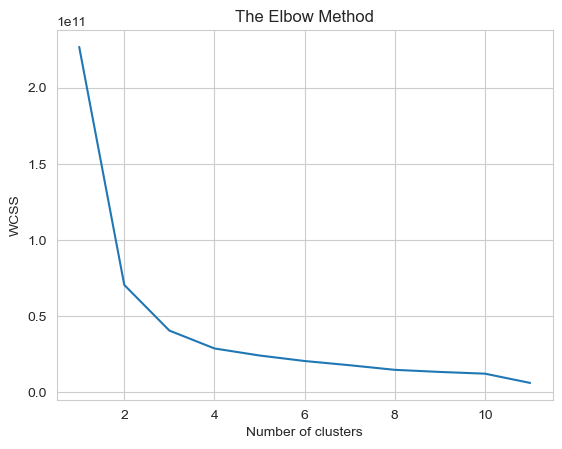

In [35]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_x)
    wcss.append(kmeans.inertia_)

kmeans = KMeans(n_clusters = 19, init = 'k-means++', random_state = 42)
kmeans.fit(train_x)
wcss.append(kmeans.inertia_)
plt.plot(range(1, 12), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 100)
y_kmeans = kmeans.fit_predict(train_x)

In [38]:
cluster_df = pd.DataFrame.from_dict({"Medial": train_y_med["med_Max_all_frames"],
                           "Lateral": train_y_lat["lat_Max_all_frames"],
                           "Cluster": y_kmeans})

<AxesSubplot:xlabel='Medial', ylabel='Lateral'>

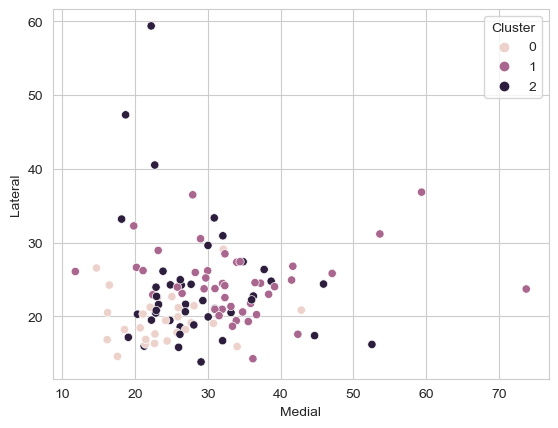

In [39]:
sns.scatterplot(data=cluster_df, x="Medial", y="Lateral", hue="Cluster")
